In [1]:
import kwant
import numpy as np
from cmath import exp
from math import pi
# For plotting
# %run matplotlib_setup.ipy
from matplotlib import pyplot
from ipywidgets import interact
import time
import sys

In [2]:
import tinyarray
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator

t=1.0
t_sc=1.0

tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])

def make_system(a=1, Delta=0.2, salt=13, U0=0.0,
                W=200, L=200, Wsc=80, Lsc=20, L_top=30, t_j=0.1, mu=0.6, mu_sc=2, phi=0):


    def hopping(site_i, site_j, phi):
        xi, yi = site_i.pos
        xj, yj = site_j.pos
        # modulated hopping in y direction
#         H1=tinyarray.array([[-t*exp(1j * pi* phi * (xi + xj) * (yi - yj)),0],\
#                             [0,t*exp(-1j * pi* phi * (xi + xj) * (yi - yj))]])
#         # modulated hopping in x direction
        H1=tinyarray.array([[-t*exp(-1j * pi* phi * (xi - xj) * (yi + yj)),0],\
                            [0,t*exp(1j * pi* phi * (xi - xj) * (yi + yj))]])
        return H1
    
    def onsite(site, mu, U0, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu + 4 * t)* tau_z
#         return  (4 * t - mu) * tau_z

    def onsite_sc(site, mu_sc, U0, Delta, salt):
        return  (U0 * (uniform(repr(site), repr(salt)) - 0.5)- mu_sc + 4 * t_sc)* tau_z+ Delta * tau_x
#         return  (4 * t_sc - mu_sc) * tau_z + Delta * tau_x

    
    lat = kwant.lattice.square(norbs=2)
    syst = kwant.Builder()
    syst[(lat(x, y) for x in range(L) for y in range(W))] = onsite
    syst[(lat(x, y) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2) ) for y in range(Wsc))] = onsite_sc
    syst[lat.neighbors()] = hopping
#     syst[([lat(x, W-1),lat(x, 0)] for x in range(L))] = -t* tau_z
    

    # Modify only those hopings in SC
    def hopping_sc(site1, site2):
        return -t_sc*tau_z
    
    def inside_sc(hop):
        x, y = hop[0].tag
        return ( (int(L/2-Lsc/2)<=x<int(L/2+Lsc/2) )  and (-1<y<Wsc) )

    def hops_inside_sc(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if inside_sc(hop):
                yield hop
    syst[hops_inside_sc] = hopping_sc

    # Modify only those hopings on SC-QH bdy
    def hopping_jn(site_i, site_j, t_j, phi):
        return -t_j*tau_z

    def crosses_ybdy(hop):
        x, y = hop[0].tag
        if y==Wsc and (int(L/2-Lsc/2) <=x< int(L/2+Lsc/2)):
            return True
        else:
            return False

    def crosses_xbdy(hop):
        x, y = hop[0].tag
        if x==int(L/2-Lsc/2) and y<Wsc :
            return True
        elif x==int(L/2+Lsc/2) and y<Wsc :
            return True
        else:
            return False

    def hops_across_xbdy(syst):
        for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
            if crosses_xbdy(hop):
                yield hop
    def hops_across_ybdy(syst):                
        for hop in kwant.builder.HoppingKind((0, 1), lat, lat)(syst):
            if crosses_ybdy(hop):
                yield hop

    syst[hops_across_xbdy] = hopping_jn
    syst[hops_across_ybdy] = hopping_jn

    
    def onsite_lead(site, mu):
        return  (- mu + 4 * t)* tau_z

    def hopping_lead(site1, site2):
        return -t*tau_z

#     sym_left = kwant.TranslationalSymmetry((-1, 0))
#     left_lead = kwant.Builder(sym_left, conservation_law=-tau_z, particle_hole=tau_y)
#     left_lead[(lat(0, y) for y in range(0,W))] = onsite_lead
#     left_lead[lat.neighbors()] = hopping
#     syst.attach_lead(left_lead)
#     syst.attach_lead(left_lead.reversed())

    sym_top = kwant.TranslationalSymmetry((0, 1))
    top_lead = kwant.Builder(sym_top, conservation_law=-tau_z, particle_hole=tau_y)
    top_lead[(lat(x, 0) for x in range(int(L/2-L/4),int(L/2+L/4))) ] = onsite_lead
    top_lead[lat.neighbors()] = hopping_lead
    syst.attach_lead(top_lead)

    sym_bottom = kwant.TranslationalSymmetry((0, -1))
    bottom_lead = kwant.Builder(sym_bottom, particle_hole=tau_y)
    bottom_lead[(lat(x, 0) for x in range(int(L/2-Lsc/2),int(L/2+Lsc/2))) ] = onsite_sc
    bottom_lead[lat.neighbors()] = hopping_sc
#     bottom_lead = kwant.Builder(sym_bottom, conservation_law=-tau_z, particle_hole=tau_y)
#     bottom_lead[(lat(x, 0) for x in range(int(L/2-L/4),int(L/2+L/4))) ] = onsite_lead
#     bottom_lead[lat.neighbors()] = hopping_lead
    syst.attach_lead(bottom_lead)
    
    return syst


def compute_conductance(syst, energies, params):
    # Compute conductance
    Pe = np.zeros(len(energies))
    Ph = np.zeros(len(energies))
    for i_e in range(len(energies)):
        energy=energies[i_e]
        smatrix = kwant.smatrix(syst, energy=energy,params=params)
        Pe[i_e]=smatrix.transmission((1, 0), (0, 0))                     
        Ph[i_e]=smatrix.transmission((1, 1), (0, 0)) 
        wfs = kwant.wave_function(syst, energy=energy, params=params)
        if i_e==0:
            # construct the wf array to be saved
            wf_arr=np.zeros((wfs(0).shape[0],wfs(0).shape[1],len(energies)),dtype=np.complex64)
        
        wf_arr[:,:,i_e]= wfs(0)
    return Pe, Ph, wf_arr
        
#     pyplot.figure()
#     pyplot.plot(np.array(energies)/Delta, np.array(Pe)-np.array(Ph))
# #     pyplot.plot(energies, Ph)
# #     pyplot.plot(energies, data)
#     pyplot.xlabel("energy [Delta]")
#     pyplot.ylabel(r"$P_e - P_h$")
#     pyplot.show()
    
def main():
    Wsc=20
    W=Wsc+10
    Lsc=20
    L=Lsc+20
    syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
    # Check that the system looks as intended.
    kwant.plot(syst)
    # Finalize the system.
    syst = syst.finalized()

    # parameters
    mu=0.1
    mu_sc=1.5
    phi=0.01
    U0=0.0 # disorder strength
    salt=13
    Delta=0.02
    t_j=0.5
    
    # Compute and plot the conductance
    E_list=np.arange(-10, 11)*Delta/10
    t_timer=time.time()
    # Compute and plot the conductance
    Pe, Ph, wf_arr= compute_conductance(syst, energies=[E for E in E_list], params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt) )
    elapsed = time.time() - t_timer
    print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")
    
    out_dir='kw_data_files/'
    fname=out_dir+ 'phi_%.2f_mu_%.2f_mus_%.2f_D_%.2f_tj_%.2f_W_%d_L_%d_Ws_%d_Ls_%d.npz' % (phi,mu,mu_sc,Delta,t_j,W,L,Wsc,Lsc)
    np.savez(fname, E_list=E_list, Pe=Pe, Ph=Ph, wf_arr=wf_arr)
    
#     pyplot.figure()
#     pyplot.plot(E_list/Delta, Pe-Ph)
#     pyplot.xlabel("energy [Delta]")
#     pyplot.ylabel(r"$P_e - P_h$")
#     pyplot.show()
    
#     def wf_plot(i_e):
#         ind=0
# #         print(wf_arr.shape)
#         kwant.plotter.map(syst, abs(wf_arr[ind,::2,i_e])**2-abs(wf_arr[ind,1::2,i_e])**2);
#     interact(wf_plot, i_e=(0,len(E_list)-1,1) )


# Call the main function if the script gets executed (as opposed to imported).

# if __name__ == '__main__':
#     main()

In [3]:
Wsc=40
W=Wsc+40
Lsc=80
L=Lsc+80
# syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# # Check that the system looks as intended.
# kwant.plot(syst)
# # Finalize the system.
# syst = syst.finalized()

# parameters
mu=0.1
mu_sc=1.5
phi=0.01
U0=0.0 # disorder strength
salt=13
Delta=0.1
t_j=0.5

out_dir='kw_data_files/'
fname=out_dir+ 'phi_%.2f_mu_%.2f_mus_%.2f_D_%.2f_tj_%.2f_W_%d_L_%d_Ws_%d_Ls_%d.npz' % (phi,mu,mu_sc,Delta,t_j,W,L,Wsc,Lsc)
npzfile = np.load(fname)
E_list=npzfile['E_list']
wf_arr=npzfile['wf_arr']
Pe=npzfile['Pe']
Ph=npzfile['Ph']


def wf_plot(Energy_index):
    i_e=Energy_index
    if not sys.warnoptions:
        import warnings
        warnings.simplefilter("ignore")
    ind=0
    pyplot.figure()
    pyplot.subplot(2,1,1)
    Zmat=abs(wf_arr[ind,::2,i_e])**2-abs(wf_arr[ind,1::2,i_e])**2
    Zmat_plot=np.fliplr(np.reshape(Zmat,[L,W])).T
    pos=pyplot.imshow(Zmat_plot, cmap='Reds')#, vmax=0.7*EE_cont.max(),
#                                 interpolation='none')
    pyplot.ylabel("x")
    pyplot.xlabel("y")
    pyplot.title(r"$E/\Delta=%.2f$" % (E_list[i_e]/Delta))

#     kwant.plotter.map(syst, abs(wf_arr[ind,::2,i_e])**2-abs(wf_arr[ind,1::2,i_e])**2);
    pyplot.ylabel(r"$y$")
    pyplot.subplot(2,1,2)
#     pyplot.figure()
    pyplot.plot(E_list/Delta, Pe-Ph);
    pyplot.plot(E_list[i_e]/Delta, Pe[i_e]-Ph[i_e],'o');
    pyplot.xlabel("energy [Delta]")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()

interact(wf_plot, Energy_index=(0,len(E_list)-1,1) );



interactive(children=(IntSlider(value=49, description='Energy_index', max=99), Output()), _dom_classes=('widge…

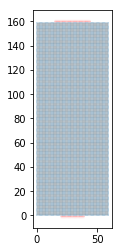

In [4]:
# def main():
Wsc=120
W=Wsc+40
Lsc=20
L=Lsc+40
syst = make_system(W=W, L=L, Wsc=Wsc, Lsc=Lsc)
# Check that the system looks as intended.
kwant.plot(syst)
# Finalize the system.
syst = syst.finalized()

(14, 19200)


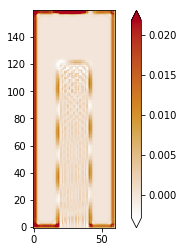

In [5]:
mu=0.6
mu_sc=1.5
phi=0.05
U0=0.0 # disorder strength
salt=13
Delta=0.06
t_j=0.6

energy=0*Delta
params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt)
wfs = kwant.wave_function(syst, energy=energy, params=params)
scattering_wf = wfs(0)  # all scattering wave functions from lead 0
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,::2])**2, axis=0)-np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
# kwant.plotter.map(syst, np.sum(abs(scattering_wf[:,1::2])**2, axis=0));
ind=0
print(scattering_wf.shape)
kwant.plotter.map(syst, abs(scattering_wf[ind,::2])**2-abs(scattering_wf[ind,1::2])**2);

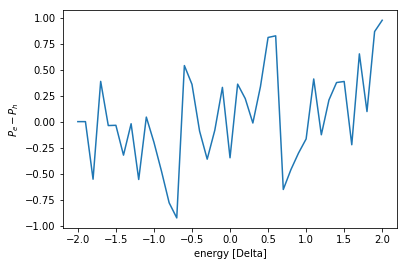

Finished, elapsed time = 95 sec


In [99]:
mu=0.1
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

    pyplot.figure()
    pyplot.plot(np.array(energies)/Delta, np.array(Pe)-np.array(Ph))
#     pyplot.plot(energies, Ph)
#     pyplot.plot(energies, data)
    pyplot.xlabel("energy [Delta]")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
E_list=np.arange(-20, 21)*Delta/10
t_timer=time.time()
# Compute and plot the conductance
plot_conductance(syst, energies=[E for E in E_list])
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
mu_sc=1.5
phi=0.01
U0=0.5 # disorder strength
salt=13
Delta=0.02
t_j=0.5

def plot_conductance(syst, mu_sw):
    # Compute conductance
    Nrep=10
    vec=np.zeros((len(mu_sw),Nrep))
#     print(np.shape(vec))
    for salt in range(Nrep):
        print(salt, end='\r')
        for i_mu in range(len(mu_sw)):
            mu=mu_sw[i_mu]
            smatrix = kwant.smatrix(syst,energy=0,params=dict(t_j=t_j,Delta=Delta,mu=mu,mu_sc=mu_sc,phi=phi,U0=U0,salt=salt))    
            # Conductance is N - R_ee + R_he
            vec[i_mu,salt]=(smatrix.transmission((1, 0), (0, 0)) -
                        smatrix.transmission((1, 1), (0, 0)))
#         vec=vec+data
#         print([np.shape(vec),np.shape(data)])
    
    cond_avg=np.mean(vec,axis=1)
    pyplot.figure()
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), vec,'b')
    pyplot.plot(np.reshape(mu_sw,[len(mu_sw),1]), cond_avg,'r')
    pyplot.xlabel(r"$\mu [t]$")
    pyplot.ylabel(r"$P_e - P_h$")
    pyplot.show()
    
# Compute and plot the conductance
plot_conductance(syst, mu_sw=[0.01 * i for i in range(5, 20)])